In [134]:
import numpy as np
import matplotlib.pyplot as plt
#import lumicks
import lumicks.pylake as lk
%matplotlib inline
from skimage.transform import rescale
import tifffile
import os
from cv2 import warpAffine,invertAffineTransform
from pathlib import Path
from cv2 import estimateAffine2D,estimateAffinePartial2D
from picasso import io, postprocess


def norm_image(image,inverse=False):          #This function is not used anymore
    amin = image.min()
    amax = image.max()
    if inverse:
        return 1- (image-amin)/(amax-amin)    
    else:
        return (image-amin)/(amax-amin)
    


In [135]:
directory = "data/output"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory created successfully!


In [136]:
irm_path="data/20240103-133417_IRM.tif"
wt_path="data/20240103-134127_WT.tif"

irm = lk.ImageStack(irm_path)  # Loading a stack.
wt = lk.ImageStack(wt_path)  # Loading a stack.

wt_exp_path="data/output/20240103-134127_WT_aligned.tif"
wt.export_tiff(wt_exp_path)


In [25]:
wt_g = wt.get_image(channel='green')
wt_r = wt.get_image(channel='red')
wt_b = wt.get_image(channel='blue')
#plt.imshow(wt_g)

irm_g = irm.get_image()


In [26]:
wt_metadata=wt._tiff_image_metadata()
wt_roi=wt_metadata['Alignment region of interest (x, y, width, height)']
print(wt_roi)

irm_metadata=irm._tiff_image_metadata()
irm_roi=irm_metadata['Region of interest (x, y, width, height)']   #This is different because the wt was previously aligned I think. Can this cause issues?
print(irm_roi)

[639, 60, 654, 597]
[0, 0, 728, 544]


In [83]:
# wt_roi=(0,0)#testing no padding  edit:Apparently it works if you don't pad it?
# irm_roi=(0,0)

wt_g_padded = np.pad(wt_g, [(int(wt_roi[0]), 0), (int(wt_roi[1]), 0)])
#plt.imshow(wt_g_padded)
tifffile.imwrite("data/output/wt_padded.tif", wt_g_padded)

irm_g_padded = np.pad(irm_g, [(int(irm_roi[0]), 0), (int(irm_roi[1]), 0)])
tifffile.imwrite("data/output/irm_padded.tif", irm_g_padded)
#plt.imshow(irm_g_padded)

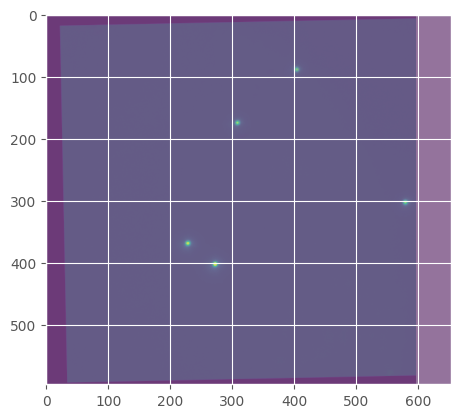

In [184]:
#Align to arbitrary matrix
    

#transform_mat_arbitrary=np.array([[1.060011859273982671e+00, 2.326021122819139919e-02, 8.187989308501457231e+01],
#                                  [-2.326021122819139919e-02, 1.060011859273982671e+00, 6.586183325618754907e+02]])

transform_mat_arbitrary=np.array([[1.05815236823145, 0.0216098979264786, 82.6092845054689],
                                  [-0.0216098979264786, 1.05815236823145, 657.939077599073]])


irm_g_padded_warped=warpAffine(irm_g_padded,transform_mat_arbitrary,(wt_g_padded.shape[1],wt_g_padded.shape[0]))

#Save aligned padded images (irm and wt_g):

#tifffile.imwrite("data/output/aligned_irm_padded.tif", irm_g_padded_warped)
#tifffile.imwrite("data/output/aligned_wt_padded.tif", wt_g_padded)

#save irm image without the padding:

tifffile.imwrite("data/output/aligned_irm.tif", 
                 irm_g_padded_warped[wt_roi[0]:wt_roi[0]+wt_g.shape[0],wt_roi[1]:wt_roi[1]+wt_g.shape[1]],metadata=irm_metadata) 
#The metadata is saved correctly, but for some reason imagej displays it weirdly in one line. Metadata is all still there, and can be accessed
#as shown below without issue.



plt.imshow(irm_g_padded_warped[wt_roi[0]:wt_roi[0]+wt_roi[2],wt_roi[1]:wt_roi[1]+wt_roi[3]], alpha=0.5)
plt.imshow(wt_g, alpha=0.5)
#plt.imshow(wt_g_padded, alpha=0.5)

#test showing that metadata is still there
#rm_test = lk.ImageStack(irm_path)  # Loading a stack.
#for item in irm_test._tiff_image_metadata():
#    print (item,irm_test._tiff_image_metadata()[item])


In [94]:
#Gradient needs to be adjusted. In dataset A it needs to be 60000, but because of a speck, in B dataset it needs to be 700000 (note the extra 0)
#dataset 20240103-134127_WT needs 70000

!python -m picasso localize data/output/wt_padded.tif --fit-method lq -b 21 --gradient 70000
!python -m picasso localize data/output/irm_padded.tif --fit-method lq -b 21 --gradient 70000


    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           data/output/wt_padded.tif
3        box_side_length 21        
4        fit_method      lq        
5        gradient        70000     
6        drift           1000      
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', files='data/output/wt_pad


LQ fitting: 100%|██████████| 1200/1200 [00:14<00:00, 85.18task/s] 

Generating segments: 0segments [00:00, ?segments/s]
Generating segments: 0segments [00:00, ?segments/s]

Correlating image pairs: 0pairs [00:00, ?pairs/s]
Correlating image pairs: 0pairs [00:00, ?pairs/s]


    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           data/output/irm_padded.tif
3        box_side_length 21        
4        fit_method      lq        
5        gradient        70000     
6        drift           1000      
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', files='data/output/irm_p


LQ fitting: 100%|██████████| 1200/1200 [00:14<00:00, 85.50task/s] 

Generating segments: 0segments [00:00, ?segments/s]
Generating segments: 0segments [00:00, ?segments/s]

Correlating image pairs: 0pairs [00:00, ?pairs/s]
Correlating image pairs: 0pairs [00:00, ?pairs/s]


In [37]:
irm_locs, irm_info = io.load_locs("data/output/irm_padded_locs.hdf5")
wt_locs, wt_info = io.load_locs("data/output/wt_padded_locs.hdf5")
print(wt_locs)
print(irm_locs)

[(0, 288.73627, 1008.53046, 3021630.2, 2.6484313, 2.6376104, 2504.256 , 0.00300769, 0.00299461, 0.00408576, 2799942.5)
 (0, 332.75928, 1042.2421 , 3878950.2, 2.8062093, 2.8389506, 2405.619 , 0.0027935 , 0.00282789, 0.01153289, 2902883. )
 (0, 368.73346,  813.9762 , 2155814.2, 2.423533 , 2.4676414, 1577.8785, 0.00322957, 0.00329098, 0.01787472, 2222546.2)
 (0, 464.4423 ,  727.95886, 1623569. , 2.4830778, 2.5599225, 1107.874 , 0.00380921, 0.00393246, 0.03001837, 1610660. )
 (0, 639.8421 ,  942.39124, 2183209. , 2.4899144, 2.563093 , 1489.5457, 0.00329432, 0.00339557, 0.02855087, 2175405.5)]
[(0, 186.98859, 334.57608 , 1038148.2, 2.9832885, 2.5130358, 28000.508, 0.01166857, 0.00868236, 0.15762898,  959456.44)
 (0, 228.07547, 366.6245  ,  839507.7, 2.196128 , 1.9100802, 27919.379, 0.00828932, 0.0065981 , 0.13025093, 1032185.8 )
 (0, 267.1932 , 152.6794  ,  776585. , 2.678649 , 2.287238 , 27716.344, 0.01244754, 0.00946501, 0.14612257,  790546.06)
 (0, 359.56818,  73.542114,  911279.6, 2.260

In [38]:
wt_locs = wt_locs[wt_locs["sx"]<3.5]
wt_locs = wt_locs[wt_locs["sy"]<3.5]
irm_locs = irm_locs[irm_locs["sx"]<3.5]
irm_locs = irm_locs[irm_locs["sy"]<3.5]
#wt_locs = wt_locs[wt_locs["photons"]<1500000]
#irm_locs = irm_locs[irm_locs["photons"]<1500000]

import math

wt_locs_xy=wt_locs[["x","y"]].copy()
irm_locs_xy=irm_locs[["x","y"]].copy()


wt_locs_xy = np.vstack([wt_locs_xy[item] for item in ['x','y']]).T.astype(np.int64) #Parse to numpy array:
irm_locs_xy = np.vstack([irm_locs_xy[item] for item in ['x','y']]).T.astype(np.int64)

print(len(wt_locs_xy))   #These need to be the same
print(len(irm_locs_xy))



5
5


In [97]:
#Delete points that are too close. ugly, but it works. Is there a better way?
#This became obsolete with making the box larger, but i'll leave it here in case it's useful

import itertools

delete_pair_list=[]
for index1,point1 in enumerate(irm_locs_xy):
    for index2,point2 in enumerate(irm_locs_xy):
        if (index1!=index2):
            distance=math.sqrt((point1[0]-point2[0])*(point1[0]-point2[0])+(point1[1]-point2[1])*(point1[1]-point2[1]))
            #print(distance)
            if distance < 5:
                print("found")
                delete_pair_list.append(sorted((index1,index2)))  #this array holds pair of point indexes that are too close


delete_pair_list.sort()
delete_pair_list=list(delete_pair_list for delete_pair_list,_ in itertools.groupby(delete_pair_list))

delete_index_list=[]
for pair in delete_pair_list:
    if irm_locs_xy[pair[0]][1]>irm_locs_xy[pair[1]][1]: 
        delete_index_list.append(pair[0])#if first item in pair is to the right, delete that one
    else:
        delete_index_list.append(pair[1]) #otherwise, this one

print(len(irm_locs_xy))
irm_locs_xy=np.delete(irm_locs_xy,delete_index_list,axis=0)
print(len(irm_locs_xy))

##Repeat for wt
delete_pair_list=[]
for index1,point1 in enumerate(wt_locs_xy):
    for index2,point2 in enumerate(wt_locs_xy):
        if (index1!=index2):
            distance=math.sqrt((point1[0]-point2[0])*(point1[0]-point2[0])+(point1[1]-point2[1])*(point1[1]-point2[1]))
            #print(distance)
            if distance < 5:
                print("found")
                delete_pair_list.append(sorted((index1,index2)))  #this array holds pair of point indexes that are too close


delete_pair_list.sort()
delete_pair_list=list(delete_pair_list for delete_pair_list,_ in itertools.groupby(delete_pair_list))

delete_index_list=[]
for pair in delete_pair_list:
    if wt_locs_xy[pair[0]][1]>wt_locs_xy[pair[1]][1]: 
        delete_index_list.append(pair[0])#if first item in pair is to the right, delete that one
    else:
        delete_index_list.append(pair[1]) #otherwise, this one

print(len(wt_locs_xy))
wt_locs_xy=np.delete(wt_locs_xy,delete_index_list,axis=0)
print(len(wt_locs_xy))




5
5
5
5


In [39]:
a=estimateAffinePartial2D(irm_locs_xy,wt_locs_xy)

#This was a test to see if it works with extra points. It doesn't.

#wt_locs_xy_00=np.vstack([wt_locs_xy, (0,0)])
#wt_locs_xy_00
#a=estimateAffinePartial2D(wt_locs_xy_00,irm_locs_xy)


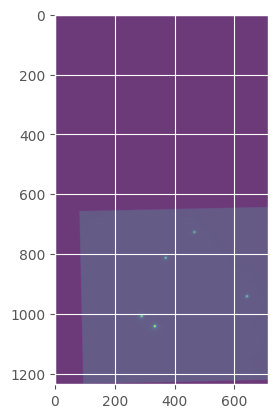

In [96]:
transform_mat=a[0]

#transform_mat_inverted=invertAffineTransform(a[0])

irm_g_padded_warped=warpAffine(irm_g_padded,transform_mat,(max(irm_g_padded.shape[1],wt_g_padded.shape[1]),max(irm_g_padded.shape[0],wt_g_padded.shape[0])))
tifffile.imwrite("data/output/aligned_irm.tif", irm_g_padded_warped[wt_roi[0]:wt_roi[0]+wt_g.shape[0],wt_roi[1]:wt_roi[1]+wt_g.shape[1]],metadata=irm_metadata) 

plt.imshow(irm_g_padded_warped, alpha=0.5)
plt.imshow(wt_g_padded, alpha=0.5)

#Print inverted matrix result to file so that I can compare them
#np.savetxt("data/output/"+Path(irm_path).stem+"_matrix.txt", transform_mat)

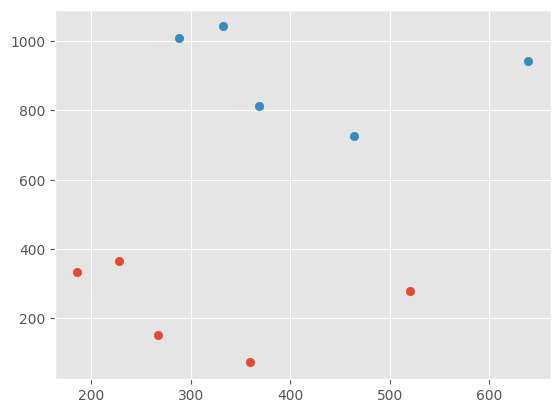

In [29]:
#Draw unaligned points
import matplotlib.pyplot as plt
plt.scatter(*zip(*irm_locs_xy))
plt.scatter(*zip(*wt_locs_xy))


In [30]:
#Manually affine transform the points

transform_mat_for_points=np.vstack([transform_mat,(0,0,1)]) #have to add this row for affine transform

warped_irm_locs=[]

for point in irm_locs_xy:
    new_point=(point[0],point[1],1) #need to add a 1 at the end of the point for affine transform
    #print(new_point)
    transformed_point=np.matmul(transform_mat_for_points,new_point) #do the transformation
    new_point=(transformed_point[0],transformed_point[1]) #transformed point
    warped_irm_locs.append(new_point)
warped_irm_locs=np.array(warped_irm_locs)

print(warped_irm_locs)

[[ 286.81100946 1008.33589427]
 [ 332.07583431 1041.2793449 ]
 [ 368.43861162  813.52965877]
 [ 464.12214598  727.64878246]
 [ 639.55239863  941.2063196 ]]


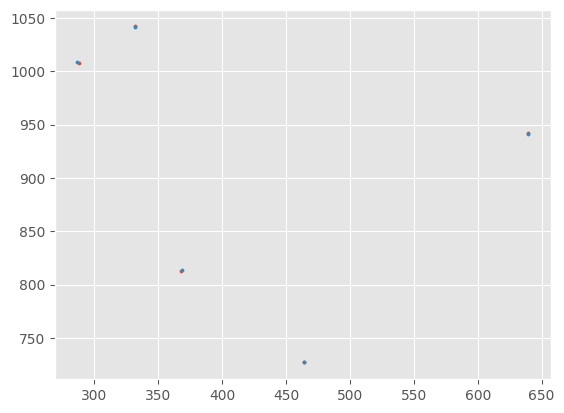

In [31]:
# Plot aligned points
plt.scatter(*zip(*wt_locs_xy), s=5)
plt.scatter(*zip(*warped_irm_locs), s=5)

In [103]:
#Get RMSD

wt_locs_xy_sorted=wt_locs_xy[np.lexsort((wt_locs_xy[:,1], wt_locs_xy[:,0]))]  #Sort the points in case they are in different orders
warped_irm_locs_sorted=warped_irm_locs[np.lexsort((warped_irm_locs[:,1], warped_irm_locs[:,0]))]

rmsd = np.sqrt(((((wt_locs_xy_sorted - warped_irm_locs_sorted)** 2))*3).mean())
print(rmsd)



1.0810480867971348
